## Final Project Submission

* Student name: **Evan Holder**
* Student pace: **Self-Paced**
* Scheduled project review date/time: **June 11, 2021, 11AM**
* Instructor name: **Jeff Herman**
* Blog post URL:https://evanholder.github.io/residual_plots


## Overview / Outline
For this module 2 project, we will use regression to model housing prices in the King County Housing dataset.  Our approach will be as outlined below.  We'll started by cleaning up the data. Then we'll separate into categorical and continuous data. Data will be logged and scaled as neccessary to fit a regression model.  Then we will define a few feature selection techniques and apply them to create our model. Lastly we will refine the model with any interaction / polynomial features as required.  Finally we will validate the model and intpret it.

1. Explore/Clean the Data
2. Explore / Deal with Categorical Variables
3. Explore / Deal with Continuous Variables
4. Feature Selection
5. Create the model(s)
6. Refine the model
7. Model Validation
8. Interpreting the Model


## 1. Explore / Clean the Data

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
sns.set_context('notebook')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# import statements
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


### Clean the data

In [2]:
# Read in the data
data = pd.read_csv('kc_house_data.csv')

# Drop unneccesary columns
data.drop(columns=['view', 'id', 'date', 'lat', 'long'], axis=1, inplace=True)

# Drop all remaining null values
data.dropna(inplace = True)

# Remove all duplicates
data.drop_duplicates(inplace=True)
print('There are {} duplicates.'.format(data.duplicated().sum()))

# Drop rows where sqft_basement = '?'
data = data.loc[data.sqft_basement != '?'].copy()

# Clean bedrooms columns, remove house with 33 bedrooms as likely a typo
data = data.loc[data.bedrooms <= 11].copy()

# Reset the index and drop index column
data.reset_index(inplace = True)
data.drop(labels='index', axis=1, inplace = True)

# Remove any categorical data which has a value_count less than 50
non_continuous = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_built', 'zipcode']
for col in non_continuous:
    count = data[col].value_counts()
    data = data.loc[data[col].isin(count.index[count>49])].copy()

There are 0 duplicates.


### Check out the scatterplots and histograms for irregularities / explore

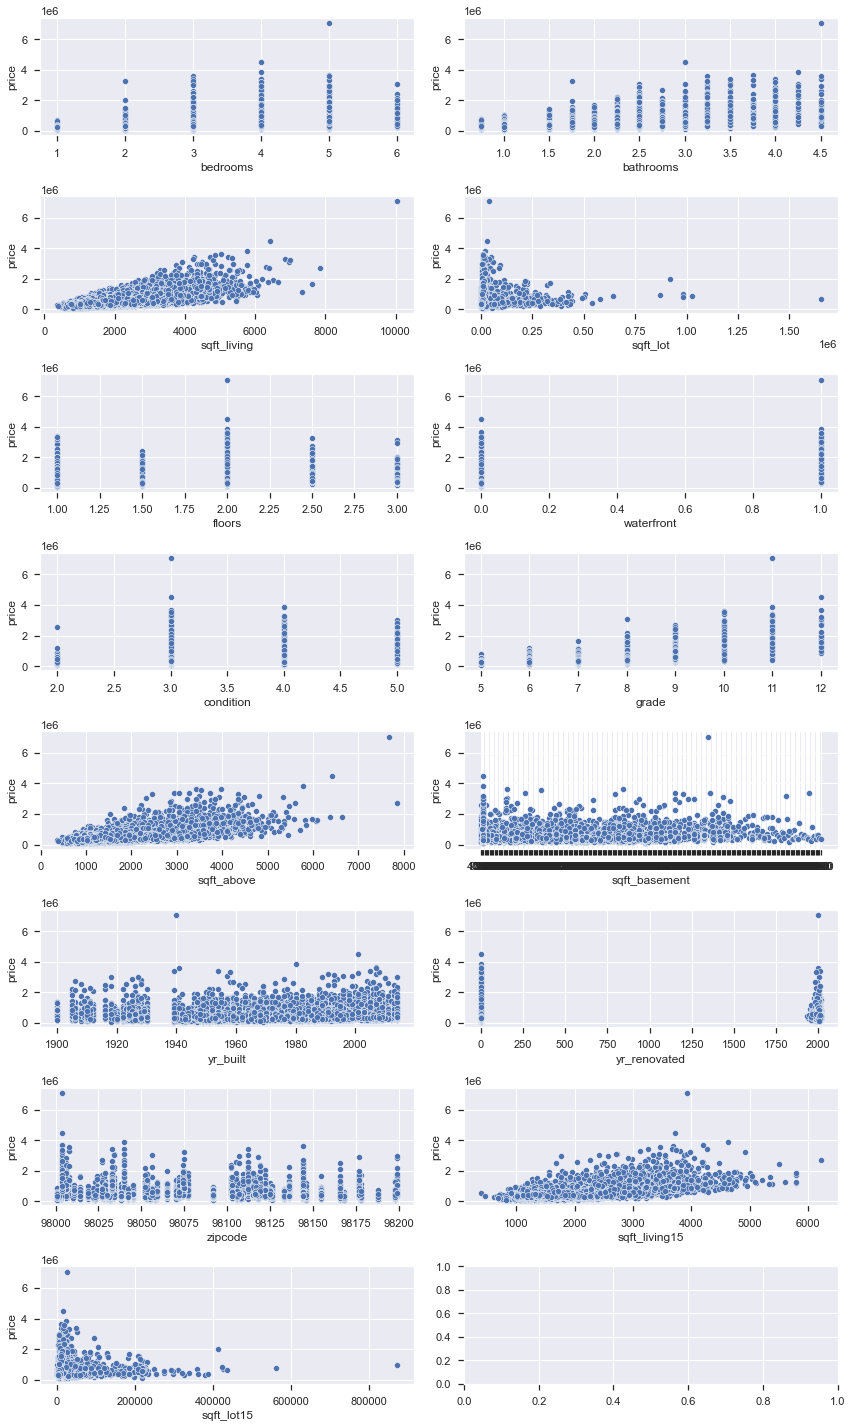

In [3]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(12, 20))
for index, col in enumerate(list(data.columns)[1:]):
    sns.scatterplot(x=data[col], y=data.price,ax=axs[index//2, index%2])
plt.tight_layout()

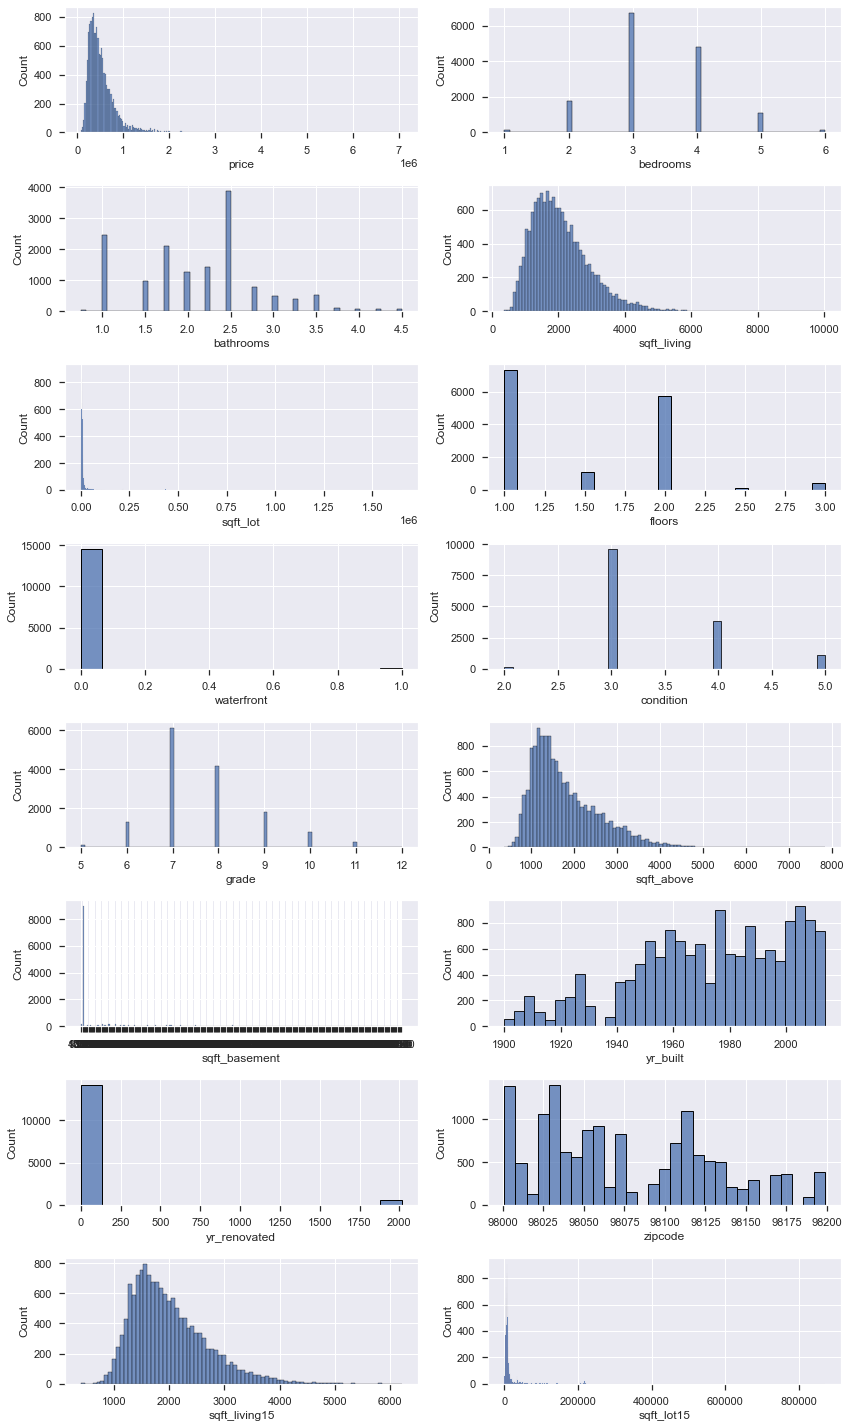

In [4]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(12, 20))
for index, col in enumerate(data.columns):
    sns.histplot(data=data, x="{}".format(col),ax=axs[index//2, index%2])
plt.tight_layout()

It appears that the continuous features `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_living15`, `sqft_lot15` all have long tails in their histograms.  Let's remove their outliers by removing the top 0.5 percentile of data in each feature and replot their histograms.

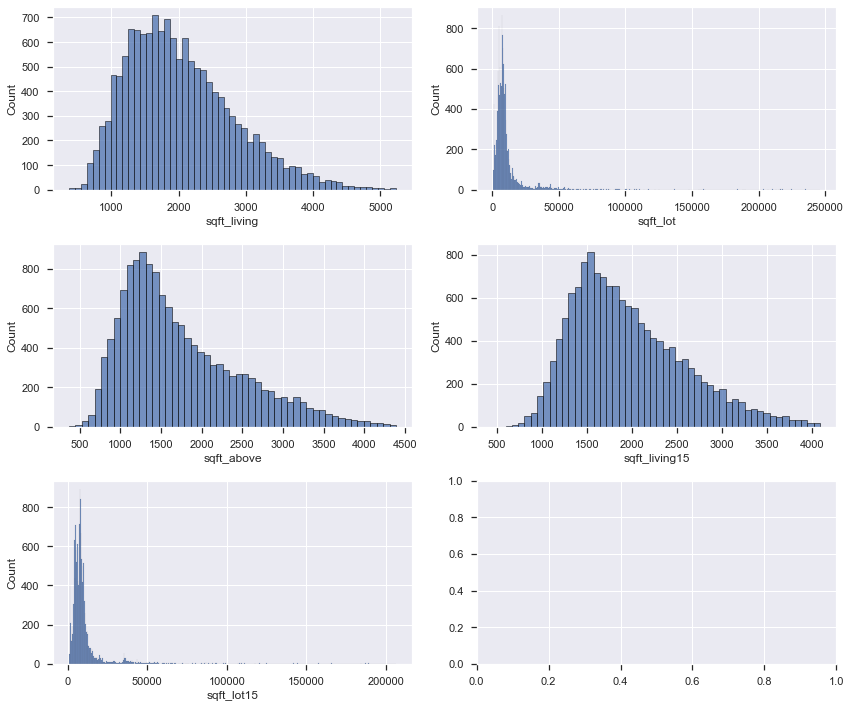

In [5]:
# List features we want to remove outliers from
outliers_to_remove = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15' ]

# Remove outliers in the top 0.5%
count = 0
for col in outliers_to_remove:
    count += data.loc[data[col] >= data[col].quantile(.995)].copy().shape[0]
    data = data.loc[data[col] < data[col].quantile(.995)].copy()

# Replot histograms
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
for index, col in enumerate(outliers_to_remove):
    sns.histplot(data=data, x="{}".format(col),ax=axs[index//2, index%2])
plt.tight_layout()

Remove Prices that are too high

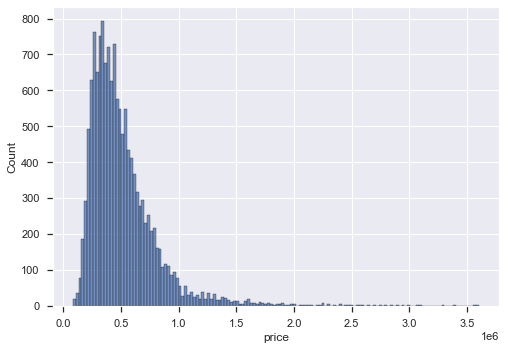

In [6]:
sns.histplot(data=data, x='price');

In [7]:
expensive_prices_to_drop = data.loc[data.price > data.price.quantile(.95)].index
data.drop(index=expensive_prices_to_drop, inplace=True)

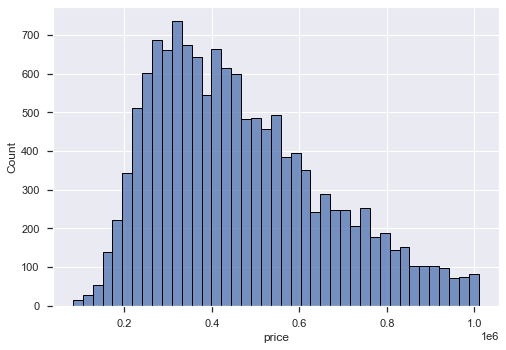

In [8]:
sns.histplot(data=data, x='price');

### Year Renovated Feature

The `yr_renovated` feature could be both categorical and continuous.  There seems to be a ton of values at zero which we will perceive to mean NOT renovated. Let's explore more.

In [9]:
count_unrenovated = data.loc[data.yr_renovated==0].yr_renovated.count()
count_renovated = data.loc[data.yr_renovated!=0].yr_renovated.count()

mean_unrenovated = round(data.loc[data.yr_renovated==0].price.mean())
mean_renovated = round(data.loc[data.yr_renovated!=0].price.mean())


print('There are {} unrenovated houses with a mean price of {}'.format(count_unrenovated, mean_unrenovated))
print('There are {} renovated houses with a mean price of {}'.format(count_renovated, mean_renovated))

There are 13130 unrenovated houses with a mean price of 462449
There are 438 renovated houses with a mean price of 556198


Since there are substantially more unrenovated houses, yet the renovated houses have a substantially greater mean than the unrenovated, we will make this feature a boolean.  A <u>zero</u> for houses unrenovated, and a <u>one</u> for houses that have been renovated.

In [10]:
data['renovated'] = data.yr_renovated.apply(lambda x: 0 if x ==0 else 1)
data.drop(columns='yr_renovated', axis = 1, inplace = True)

### Square Feet Basement Feature

Similar to `yr_renovated`, the `sqft_basement` feature could be both categorical and continuous.  There seems to be a ton of values at zero which we will perceive to mean there is NO basement. Let's explore more.

In [11]:
count_no_basement = data.loc[data.sqft_basement=='0.0'].sqft_basement.count()
count_basement = data.loc[data.sqft_basement!='0.0'].sqft_basement.count()

mean_no_basement = round(data.loc[data.sqft_basement=='0.0'].price.mean())
mean_basement = round(data.loc[data.sqft_basement!='0.0'].price.mean())


print('There are {} houses without a basement with a mean price of {}'.format(count_no_basement, mean_no_basement))
print('There are {} houses with a basement with a mean price of {}'.format(count_basement, mean_basement))

There are 8470 houses without a basement with a mean price of 444041
There are 5098 houses with a basement with a mean price of 501088


Since again there are a substantial amount of houses without a basement, it does not make sense to make this variable continuous.  On the flip side, the mean sale price for houses with a basement are very is significantly different than those without.  This should be reflected somehow in the model.  Lets make this feature a boolean.  A <u>zero</u> for houses wihtout a basement, and a <u>one</u> for houses that have a basement.

In [12]:
# Make feature basement (boolean) to tell if house has a basement
data['basement'] = data.sqft_basement.apply(lambda x: 0 if x == "0.0" else 1)
data.drop(columns='sqft_basement', axis = 1, inplace = True)

### Eliminate features that DO NOT appear to have any relationship with price
Looking back at our scatterplots, not all variables appear to have a relationship with price. Let's remove `sqft_lot` and `sqft_lot15`.  Both features `sqft_basement` and `year_renovated` have already been changed to boolean features.

In [13]:
data.drop(columns=['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)

### Separate Continuous and Categorical Data

In [14]:
# Set the dependent variable
dependent = ['price']

# Set the categorical features
categorical = ['zipcode', 'waterfront', 'renovated', 'basement']

# Set the continuous features
continuous = list(set(data.columns) - set(categorical) - set(dependent))

## 2. Categorical Features - create the dummy variables for the appropriate categorical data

In [15]:
#Convert zipcode data to string
data['zipcode'] = data['zipcode'].astype(str).copy()

#df['yr_built'] = df['yr_built'].astype(str).copy()

#Create dummy variables for zipcode
df = pd.get_dummies(data = data, columns = ['zipcode'], drop_first=True)

## 3. Continuous Features - Normalize and Scale 

In [16]:
# Take the log of the continuous data
df[continuous] = np.log(df[continuous])

# Standardize the data
scaler = StandardScaler()
df[continuous] = scaler.fit_transform(df[continuous])

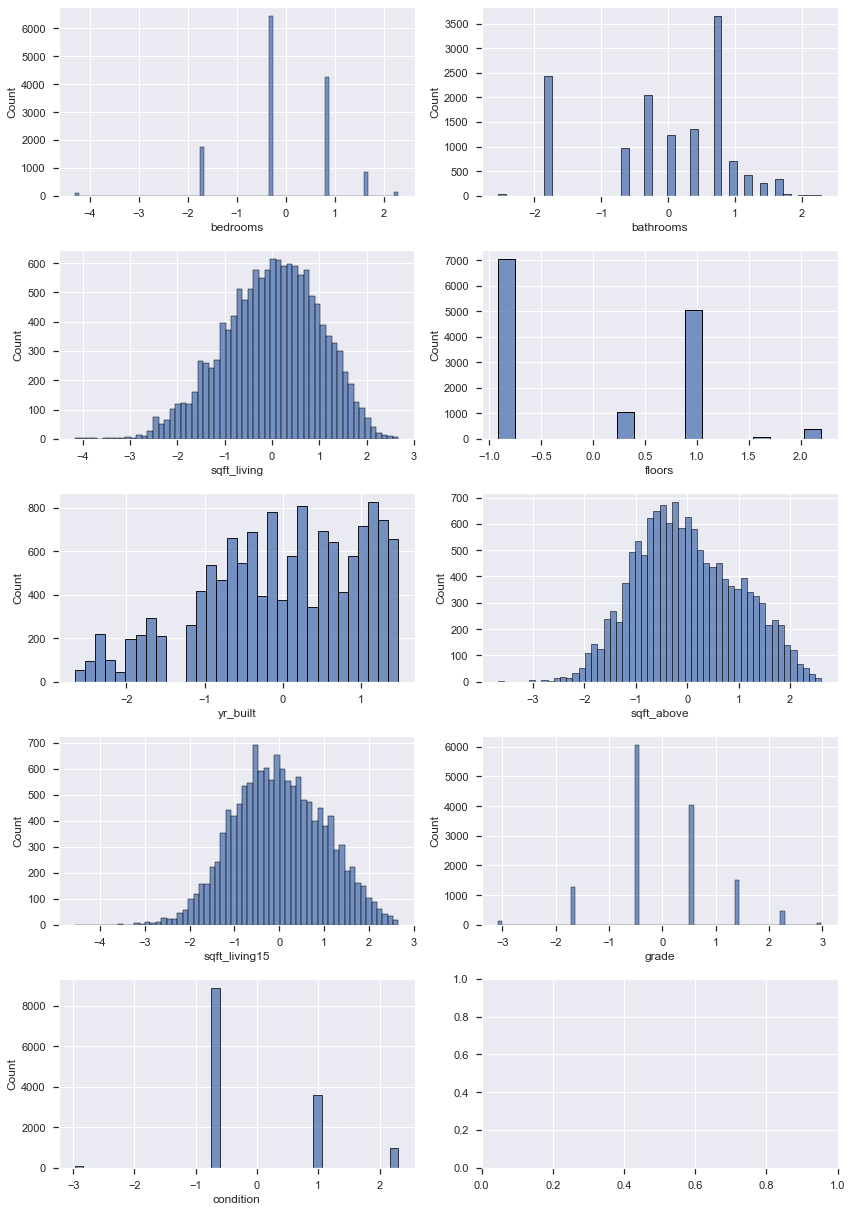

In [17]:
# Replot histograms
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 17))
for index, col in enumerate(continuous):
    sns.histplot(data=df, x="{}".format(col),ax=axs[index//2, index%2])
plt.tight_layout()

### Create scatter matrix to look at multicolinearity of any variables

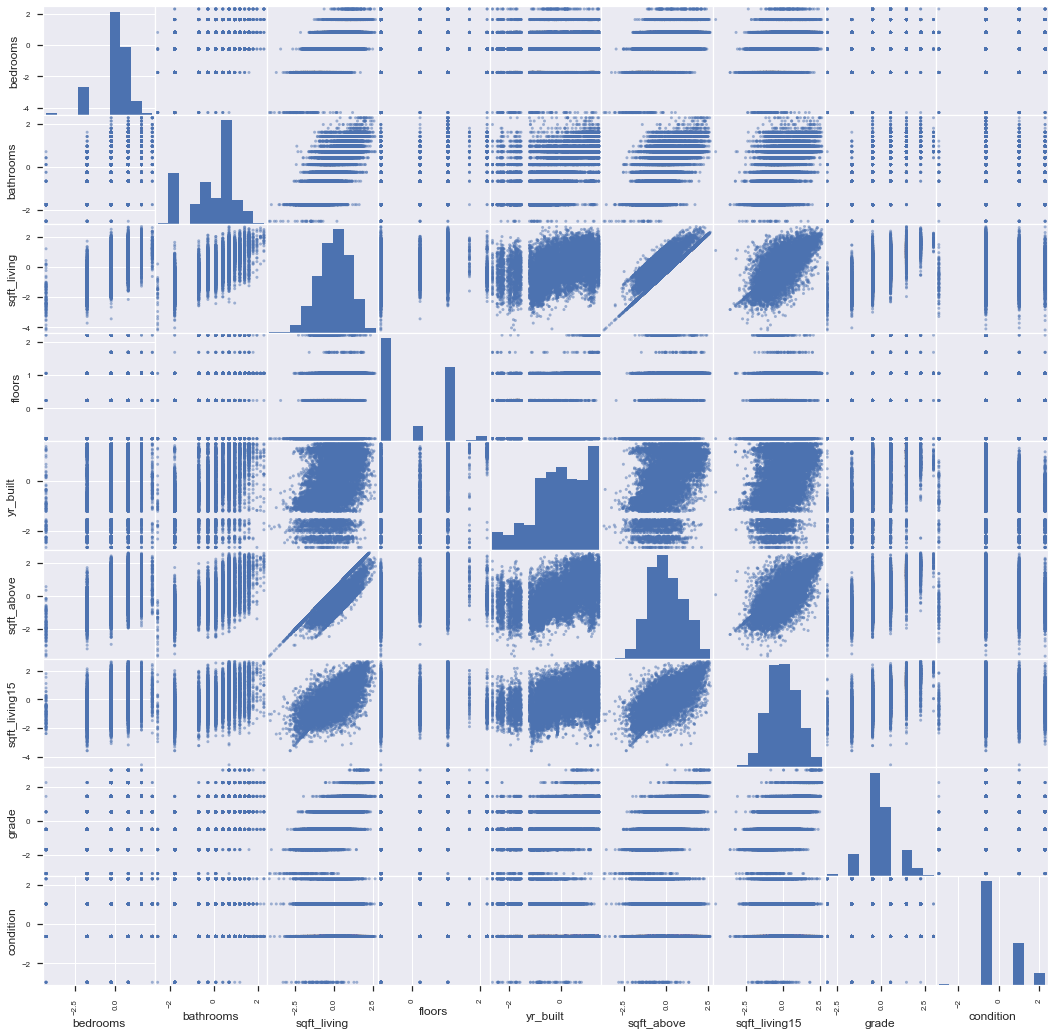

In [18]:
pd.plotting.scatter_matrix(df[continuous],figsize  = [18, 18]);
plt.show()

In [19]:
# Create Dataframe with each feature pair, ordered by correlation descending
X_corr=df[continuous].corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
X_corr['pairs'] = list(zip(X_corr.level_0, X_corr.level_1))

# set index to pairs
X_corr.set_index(['pairs'], inplace = True)

#drop level columns
X_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
X_corr.columns = ['cc']

# Drop duplicates
X_corr.drop_duplicates(inplace=True)

# View only correlations between 0.75 and 1
X_corr[(X_corr.cc>.75) & (X_corr.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.838672


We eliminate the above correlation. Let's remove `sqft_above` since `sqft_living` has appears to have a stronger correlation with price on our scatterplots above.

In [20]:
# Drop sqft_living, sqft_basement, and grade features
df.drop(columns = ['sqft_above'], axis=1, inplace = True)

# Reset index
df.reset_index(inplace=True)
df.drop(columns = 'index', inplace=True)


## 4.0 Feature Selection

Split the dataframe into independent variables (X) and dependent variables (y)

In [21]:
X = df.drop(columns='price', axis=1)
y = df.price

### 4.A Stepwise Selection with Backward Step

In [22]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [23]:
features_A = stepwise_selection(X=X, y=y)

Add  grade                          with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  zipcode_98023                  with p-value 7.20904e-138
Add  zipcode_98004                  with p-value 4.71872e-113
Add  zipcode_98042                  with p-value 1.44468e-81
Add  zipcode_98092                  with p-value 2.87645e-88
Add  zipcode_98003                  with p-value 2.39851e-94
Add  zipcode_98058                  with p-value 2.05632e-77
Add  zipcode_98030                  with p-value 4.17456e-69
Add  zipcode_98031                  with p-value 2.4812e-72
Add  zipcode_98038                  with p-value 1.2025e-78
Add  sqft_living15                  with p-value 3.8949e-77
Add  zipcode_98055                  with p-value 4.20763e-66
Add  zipcode_98198                  with p-value 2.11766e-68
Add  zipcode_98032                  with p-value 2.41278e-61
Add  zipcode_98040                  with p-value 

### 4.B.1 Backward Selection

Start with a model including all features.  Get the list of pvalues for each feature, then remove the worst pvalue (if greater than 0.05).  Stop the selectio when no pvalues greater than 0.05.

In [24]:
def backward_elimation(X, y):
    """ Perform a backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - pandas.DataSeries with dependent variable
    Returns: list of selected features 
    """
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
            print('Remove ', feature_with_p_max)
        else:
            return cols


In [25]:
features_B1 = backward_elimation(X, y)

Remove  zipcode_98030
Remove  zipcode_98032
Remove  zipcode_98003
Remove  bathrooms
Remove  zipcode_98031
Remove  zipcode_98022
Remove  zipcode_98042
Remove  zipcode_98002


### 4.B.2 Backward Selection Dropping all Zipcodes

Since there are so many zipcodes, lets use the backward selection algorithm to select features again, except we will omit the zipcode feature to see if anything changes.

In [26]:
df_2 = df.drop(columns = list(df.columns[12:]), axis=1).copy()
X_2 = df_2.drop(columns='price', axis=1).copy()

In [27]:
features_B2 = backward_elimation(X_2, y)

## 5. Create the Model

### Model A:
Create model using feature selected with <u>Stepwise Selection with Backward Step</u>

In [28]:
X_A = X[features_A]
X_A_w_intercept = sm.add_constant(X_A)
model_A = sm.OLS(y, X_A_w_intercept).fit()
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     830.1
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:59:38   Log-Likelihood:            -1.7320e+05
No. Observations:               13568   AIC:                         3.465e+05
Df Residuals:                   13497   BIC:                         3.471e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.312e+05   2439.588    135.753      0.000    3.26e+05    3.36e+05
grade          4.601e+04   1239.751     37.113      0.000    4.36e+04    4.84e+04
yr_built      -1.717e+04   1074.526    -15.980      0.000   -1.93e+04   -1.51e+04
sqft_living    7.643e+04   1495.382     51.112      0.000    7.35e+04    7.94e+04
zipcode_98023  -4.21e+04   5090.409     -8.270      0.000   -5.21e+04   -3.21e+04
zipcode_98004  4.506e+05   8830.475     51.028      0.000    4.33e+05    4.68e+05
zipcode_98042 -1.354e+04   4886.408     -2.770      0.006   -2.31e+04   -3959.396
zipcode_98092 -3.739e+04   6035.409     -6.196      0.000   -4.92e+04   -2.56e+04
zipcode_98003 -2.904e+04   6298.641     -4.611      0.000   -4.14e+04   -1.67e+04
zipcode_98030 -2.676e+04   6797.361     -3.936      0.000   -4.01e+04   -1.34e+04
zipcode_98031  -1.75e+04   6543.691     -2.674      0.008   -3.03e+04   -4671.871
sqft_living15  2.691e+04   1224.988     21.971      0.000    2.45e+04    2.93e+04
zipcode_98032 -2.405e+04   8946.462     -2.688      0.007   -4.16e+04   -6509.177
zipcode_98040  3.746e+05   8739.495     42.865      0.000    3.57e+05    3.92e+05
zipcode_98033  2.827e+05   5891.107     47.990      0.000    2.71e+05    2.94e+05
zipcode_98117  2.863e+05   5302.462     53.986      0.000    2.76e+05    2.97e+05
zipcode_98115  2.848e+05   5322.788     53.502      0.000    2.74e+05    2.95e+05
zipcode_98103  2.751e+05   5199.883     52.903      0.000    2.65e+05    2.85e+05
zipcode_98112  3.624e+05   9374.770     38.656      0.000    3.44e+05    3.81e+05
zipcode_98199  3.088e+05   7338.720     42.075      0.000    2.94e+05    3.23e+05
zipcode_98119  3.597e+05   9713.745     37.029      0.000    3.41e+05    3.79e+05
zipcode_98107  2.857e+05   6854.412     41.681      0.000    2.72e+05    2.99e+05
zipcode_98105  3.319e+05   8838.502     37.552      0.000    3.15e+05    3.49e+05
zipcode_98005  3.048e+05   8518.824     35.785      0.000    2.88e+05    3.22e+05
zipcode_98116   2.68e+05   6465.344     41.450      0.000    2.55e+05    2.81e+05
zipcode_98006  2.479e+05   5798.942     42.745      0.000    2.37e+05    2.59e+05
zipcode_98052  2.297e+05   4978.277     46.137      0.000     2.2e+05    2.39e+05
zipcode_98053  2.228e+05   5889.461     37.823      0.000    2.11e+05    2.34e+05
zipcode_98122  2.731e+05   7369.938     37.057      0.000    2.59e+05    2.88e+05
zipcode_98109   3.56e+05   1.22e+04     29.089      0.000    3.32e+05     3.8e+05
waterfront     2.422e+05    1.5e+04     16.126      0.000    2.13e+05    2.72e+05
zipcode_98102  3.597e+05   1.34e+04     26.841      0.000    3.33e+05    3.86e+05
zipcode_98075  2.253e+05   6298.503     35.771      0.000    2.13e+05    2.38e+05
zipcode_98136    2.4e+05   7109.696     33.755      0.000    2.26e+05    2.54e+05
condition      1.269e+04    829.267     15.298   

Create Q-Q Plot to look at the residuals.

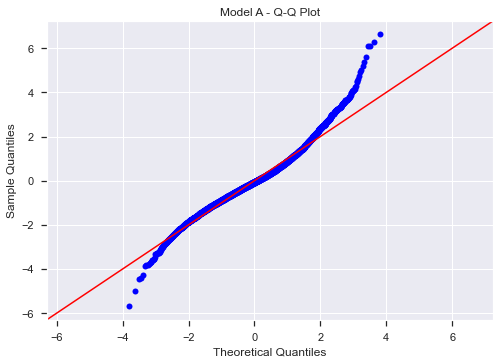

In [29]:
residuals_model_A = model_A.resid
fig = sm.graphics.qqplot(residuals_model_A, dist=stats.norm, line='45', fit=True)
plt.title('Model A - Q-Q Plot');

### Model B:
Create model using feature selected with <u>Backward Selection</u>

In [30]:
X_B1 = X[features_B1]
X_B1_w_intercept = sm.add_constant(X_B1)
model_B1 = sm.OLS(y, X_B1_w_intercept).fit()
model_B1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     832.6
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:59:38   Log-Likelihood:            -1.7318e+05
No. Observations:               13568   AIC:                         3.465e+05
Df Residuals:                   13497   BIC:                         3.470e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.118e+05   2224.007    140.207      0.000    3.07e+05    3.16e+05
bedrooms      -6990.9822    987.556     -7.079      0.000   -8926.729   -5055.235
sqft_living    7.773e+04   1546.330     50.268      0.000    7.47e+04    8.08e+04
floors        -2671.9456   1094.622     -2.441      0.015   -4817.557    -526.334
waterfront     2.414e+05    1.5e+04     16.047      0.000    2.12e+05    2.71e+05
condition       1.29e+04    830.339     15.538      0.000    1.13e+04    1.45e+04
grade          4.566e+04   1237.604     36.895      0.000    4.32e+04    4.81e+04
yr_built       -1.54e+04   1178.693    -13.069      0.000   -1.77e+04   -1.31e+04
sqft_living15  2.666e+04   1224.136     21.777      0.000    2.43e+04    2.91e+04
renovated      3.514e+04   4344.636      8.088      0.000    2.66e+04    4.37e+04
basement      -2.644e+04   1931.938    -13.688      0.000   -3.02e+04   -2.27e+04
zipcode_98004  4.709e+05   8770.641     53.695      0.000    4.54e+05    4.88e+05
zipcode_98005   3.24e+05   8452.826     38.334      0.000    3.07e+05    3.41e+05
zipcode_98006  2.676e+05   5692.585     47.004      0.000    2.56e+05    2.79e+05
zipcode_98007  2.416e+05   9122.522     26.481      0.000    2.24e+05    2.59e+05
zipcode_98008  2.325e+05   6475.774     35.897      0.000     2.2e+05    2.45e+05
zipcode_98010  9.698e+04   1.13e+04      8.612      0.000    7.49e+04    1.19e+05
zipcode_98011   1.33e+05   7706.672     17.262      0.000    1.18e+05    1.48e+05
zipcode_98014  1.314e+05   1.03e+04     12.757      0.000    1.11e+05    1.52e+05
zipcode_98019  8.885e+04   8434.332     10.535      0.000    7.23e+04    1.05e+05
zipcode_98023 -2.282e+04   4982.891     -4.579      0.000   -3.26e+04   -1.31e+04
zipcode_98024  1.692e+05   1.39e+04     12.151      0.000    1.42e+05    1.96e+05
zipcode_98027  1.928e+05   5692.005     33.872      0.000    1.82e+05    2.04e+05
zipcode_98028   1.26e+05   6392.081     19.715      0.000    1.13e+05    1.39e+05
zipcode_98029   2.19e+05   6039.793     36.261      0.000    2.07e+05    2.31e+05
zipcode_98033  3.025e+05   5796.193     52.187      0.000    2.91e+05    3.14e+05
zipcode_98034  1.854e+05   4921.902     37.677      0.000    1.76e+05    1.95e+05
zipcode_98038  3.511e+04   4743.309      7.402      0.000    2.58e+04    4.44e+04
zipcode_98040  3.942e+05   8666.814     45.481      0.000    3.77e+05    4.11e+05
zipcode_98045  1.188e+05   7366.348     16.134      0.000    1.04e+05    1.33e+05
zipcode_98052  2.495e+05   4855.408     51.380      0.000     2.4e+05    2.59e+05
zipcode_98053  2.413e+05   5779.592     41.745      0.000     2.3e+05    2.53e+05
zipcode_98055  3.141e+04   6650.548      4.722      0.000    1.84e+04    4.44e+04
zipcode_98056   1.06e+05   5378.986     19.705      0.000    9.55e+04    1.17e+05
zipcode_98058  2.838e+04   5281.250      5.374   

Create Q-Q Plot to look at the residuals.

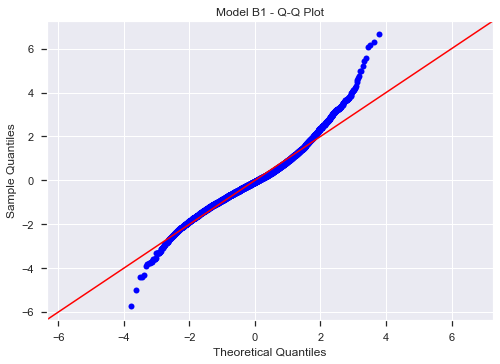

In [31]:
residuals_model_B1 = model_B1.resid
fig = sm.graphics.qqplot(residuals_model_B1, dist=stats.norm, line='45', fit=True)
plt.title('Model B1 - Q-Q Plot');

It appears that both model are performing about the same, which makes sense since both models only eliminated a few zipcodes as variables.  Let's make another model and eliminate the zipcode variable to see if that changes the residuals on the Q-Q plots.

### Model B2:
Create model using feature selected with <u>Backward Selection</u> but drop the `zipcode` dummy variables

In [32]:
X_B2 = X[features_B2]
X_B2_w_intercept = sm.add_constant(X_B2)
model_B2 = sm.OLS(y, X_B2_w_intercept).fit()
model_B2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1446.
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:59:39   Log-Likelihood:            -1.7925e+05
No. Observations:               13568   AIC:                         3.585e+05
Df Residuals:                   13556   BIC:                         3.586e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.539e+05   1564.370    290.128      0.000    4.51e+05    4.57e+05
bedrooms      -1.751e+04   1523.241    -11.495      0.000   -2.05e+04   -1.45e+04
bathrooms      1.047e+04   2014.685      5.198      0.000    6524.153    1.44e+04
sqft_living    4.451e+04   2460.792     18.088      0.000    3.97e+04    4.93e+04
floors         2.946e+04   1559.960     18.887      0.000    2.64e+04    3.25e+04
waterfront     1.394e+05   2.25e+04      6.203      0.000    9.54e+04    1.83e+05
condition      1.012e+04   1259.317      8.036      0.000    7651.152    1.26e+04
grade          9.073e+04   1790.259     50.680      0.000    8.72e+04    9.42e+04
yr_built      -7.269e+04   1676.521    -43.355      0.000    -7.6e+04   -6.94e+04
sqft_living15  3.384e+04   1788.604     18.920      0.000    3.03e+04    3.73e+04
renovated      1.966e+04   6787.708      2.897      0.004    6356.429     3.3e+04
basement       2.825e+04   2772.264     10.190      0.000    2.28e+04    3.37e+04
==============================================================================
Omnibus:                      237.547   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.735
Skew:                           0.301   Prob(JB):                     6.55e-57
Kurtosis:                       3.309   Cond. No.                         39.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

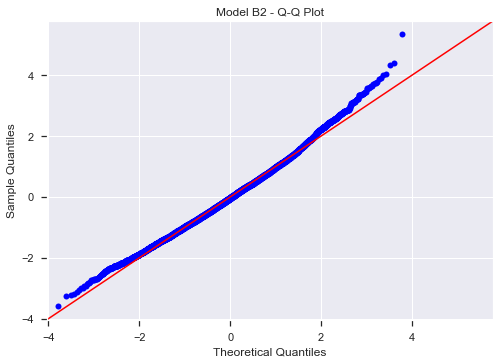

In [33]:
residuals_model_B2 = model_B2.resid
fig = sm.graphics.qqplot(residuals_model_B2, dist=stats.norm, line='45', fit=True)
plt.title('Model B2 - Q-Q Plot');

### Comparing Models A, B1, B2

Model A and B1 had both the same R squared (and adjusted R squared) values, meaning that their 'goodness of fit' was about the same.  Both feature selection techniques (forward with backward step, and backward selection) eliminated a few `zipcode` dummy variables (backward selection alsod ropped `bathrooms`), so it's no surprise that their R squared's are similar.

In Model B2, we removed all the `zipcode` variables (and `bathrooms`) to see how that would affect the model.  The model peformed significantly worse with R squared of 0.567.

Let's select Model B1 as the model to use for now. Model A was comparable in R-squared however it takes longer to select features that way and we will be rerunning the model as we go many times.  For brevity, we will go with Model B1 and backward selection.

### 6.0 Refine the Model
Let's see if we can improve the model with any higher order polynomial features. First we will plot the scatterplots one more time.


**<u> NOTE: After removing the top 5% of the most expensive houses, it would no longer be recommended to run the code below to add polynomial and interaction features as the model appear to run well with out them. The risk in adding these features is overfitting the model to the training data. For consistency with the rest of the project code, I will assign model_B4 == model_B1 then move to section 7.0 skipping section 6.0**

In [34]:
features_B4 = features_B1
model_B4 = model_B1

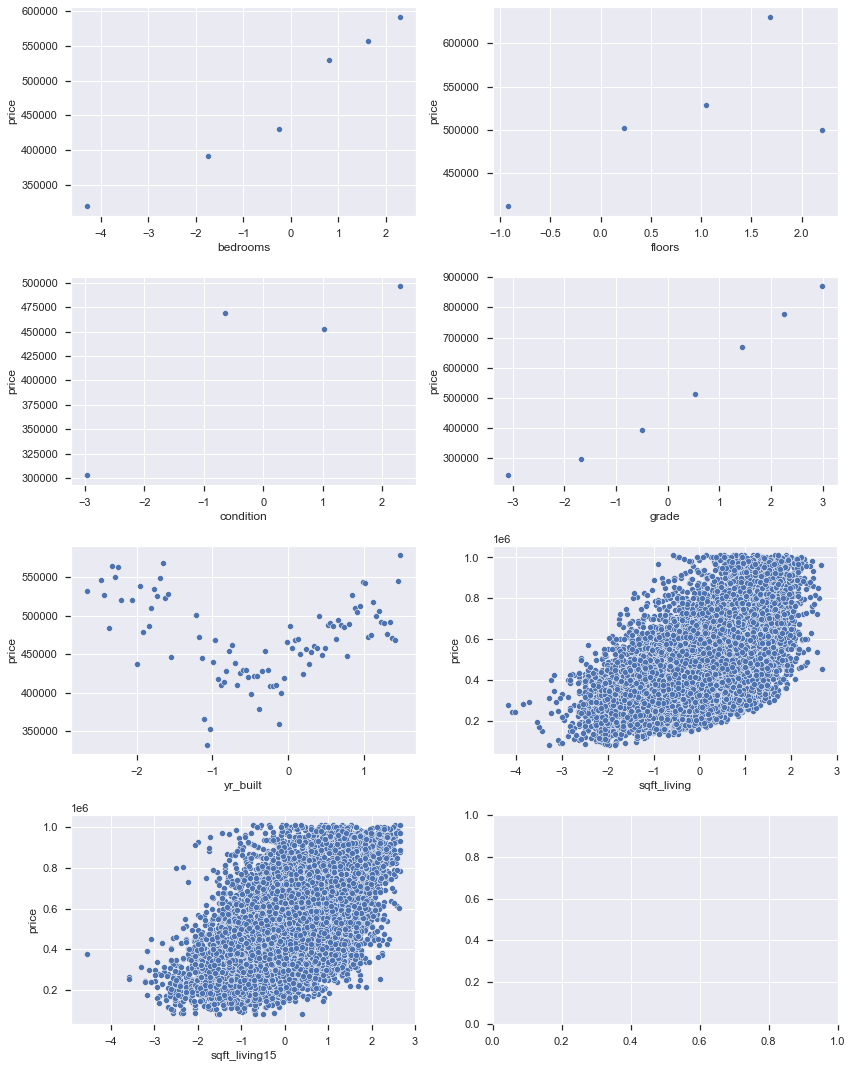

In [35]:
# Plot scatterplots for data
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))
for index, col in enumerate(['bedrooms', 'floors',
       'condition', 'grade', 'yr_built', 'sqft_living', 'sqft_living15']):
    if index <= 4:
        temp = df.groupby(by=col).mean()
        sns.scatterplot(x=temp.index, y=temp.price, ax=axs[index//2, index%2])
    else:
        sns.scatterplot(x=df[col], y=df.price, ax=axs[index//2, index%2])
plt.tight_layout()

Looks like `sqft_living`, `sqft_living15`, `grade` could all have a second order term. Lets add them to the model with the features from Model B to see if it improves.

In [36]:
# Identify features to make squared terms of
poly_features = ['sqft_living','sqft_living15', 'grade']

# Square each feature and add it to a new column
for feature in poly_features:
    df['{}_sqr'.format(feature)] = df[feature]**2
    X['{}_sqr'.format(feature)] = X[feature]**2

Reperform backward selection:

In [37]:
features_B3 = backward_elimation(X, y)

Remove  zipcode_98032
Remove  zipcode_98003
Remove  zipcode_98030
Remove  zipcode_98002
Remove  zipcode_98042
Remove  zipcode_98022
Remove  zipcode_98031


In [38]:
# Create new model with squared features
X_B3 = X[features_B3].copy()
X_B3_w_intercept_3 = sm.add_constant(X_B3)
model_B3 = sm.OLS(y, X_B3_w_intercept_3).fit()
model_B3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     879.4
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:38:39   Log-Likelihood:            -1.7257e+05
No. Observations:               13568   AIC:                         3.453e+05
Df Residuals:                   13493   BIC:                         3.458e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.887e+05   2239.421    128.898      0.000    2.84e+05    2.93e+05
bedrooms          -2648.2915    961.978     -2.753      0.006   -4533.903    -762.680
bathrooms          6212.8934   1255.847      4.947      0.000    3751.258    8674.529
sqft_living        7.586e+04   1581.311     47.973      0.000    7.28e+04     7.9e+04
floors            -5285.9339   1074.626     -4.919      0.000   -7392.351   -3179.517
waterfront         2.386e+05   1.44e+04     16.594      0.000     2.1e+05    2.67e+05
condition          1.415e+04    799.371     17.698      0.000    1.26e+04    1.57e+04
grade                4.3e+04   1195.859     35.956      0.000    4.07e+04    4.53e+04
yr_built          -1.197e+04   1223.790     -9.784      0.000   -1.44e+04   -9574.992
sqft_living15      2.385e+04   1194.354     19.968      0.000    2.15e+04    2.62e+04
renovated          3.898e+04   4200.923      9.279      0.000    3.07e+04    4.72e+04
basement          -1.912e+04   1891.386    -10.109      0.000   -2.28e+04   -1.54e+04
zipcode_98004      4.767e+05   8385.669     56.849      0.000     4.6e+05    4.93e+05
zipcode_98005      3.188e+05   8083.200     39.442      0.000    3.03e+05    3.35e+05
zipcode_98006      2.571e+05   5453.687     47.135      0.000    2.46e+05    2.68e+05
zipcode_98007      2.413e+05   8719.775     27.673      0.000    2.24e+05    2.58e+05
zipcode_98008       2.36e+05   6192.638     38.102      0.000    2.24e+05    2.48e+05
zipcode_98010      7.971e+04   1.08e+04      7.392      0.000    5.86e+04    1.01e+05
zipcode_98011       1.32e+05   7368.195     17.918      0.000    1.18e+05    1.46e+05
zipcode_98014      1.194e+05   9852.272     12.116      0.000       1e+05    1.39e+05
zipcode_98019      9.056e+04   8062.381     11.233      0.000    7.48e+04    1.06e+05
zipcode_98023     -2.678e+04   4765.630     -5.618      0.000   -3.61e+04   -1.74e+04
zipcode_98024      1.605e+05   1.33e+04     12.054      0.000    1.34e+05    1.87e+05
zipcode_98027      1.817e+05   5450.076     33.348      0.000    1.71e+05    1.92e+05
zipcode_98028      1.289e+05   6111.922     21.091      0.000    1.17e+05    1.41e+05
zipcode_98029      2.181e+05   5776.913     37.755      0.000    2.07e+05    2.29e+05
zipcode_98033      3.025e+05   5540.105     54.605      0.000    2.92e+05    3.13e+05
zipcode_98034      1.874e+05   4707.318     39.802      0.000    1.78e+05    1.97e+05
zipcode_98038      3.636e+04   4535.298      8.018      0.000    2.75e+04    4.53e+04
zipcode_98040      3.861e+05   8301.192     46.513      0.000     3.7e+05    4.02e+05
zipcode_98045      1.182e+05   7040.903     16.792      0.000    1.04e+05    1.32e+05
zipcode_98052      2.446e+05   4643.631     52.684      0.000    2.36e+05    2.54e+05
zipcode_98053      2.373e+05   5529.401     42.922      0.000    2.26e+05

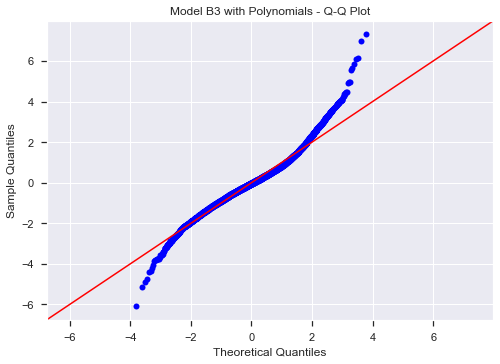

In [39]:
residuals_model_B3 = model_B3.resid
fig = sm.graphics.qqplot(residuals_model_B3, dist=stats.norm, line='45', fit=True)
plt.title('Model B3 with Polynomials - Q-Q Plot');

### Interaction Terms
The model still seems like it needs some improvement.  Let's check out how the features interact.  Since there are so many zipcode dummy variables, we will limit the scope to search between interactions other than those of zipcode variables.  In the cell below, we will create all possible combinations of interactions.

In [40]:
# Identify interaction features, leave out zipcodes
interaction_features = list(X.columns[:11])

# Create interaction terms
poly = PolynomialFeatures(interaction_only=True)
X_interaction = sm.add_constant(X[interaction_features])
X_tr = poly.fit_transform(X_interaction)
#X_interaction = X_interaction.reset_index().drop(columns='index').copy()

# Drop features that are not the new interaction features
drop_feats = ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']

# Create new dataframe with all new interaction features
interaction_df = pd.DataFrame(X_tr,columns=poly.get_feature_names()).drop(drop_feats,1)

# rename each column with appropriate interaction features
feature_key = {'x0':'bedrooms', 'x1':'bathrooms', 'x2': 'bathrooms','x3': 'sqft_living',
               'x4':'floors', 'x5':'waterfront', 'x6':'condition', 'x7':'grade', 'x8':'yr_built',
               'x9':'sqft_living15', 'x10':'renovated', 'x11':'basement'}

for col in interaction_df.columns:
    var1, var2 = col.split()
    var1_name = feature_key[var1]
    var2_name = feature_key[var2]
    interaction_df.rename(columns = {col:var1_name +' '+ var2_name}, inplace = True)
    
# Combine interaction features with all the possible interactions
Xt = pd.concat([X_interaction,interaction_df],1)

Now that we have a dataframe with the same features of <u>Model B2</u> plus the new interaction features. Lets fit a model and see how it does, we can compare the results with <u>Model C</u>.

In [41]:
# Create model with all possible interactions
mod_interaction = sm.OLS(y.reset_index().drop(columns='index'), Xt).fit()
mod_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     277.9
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:39:07   Log-Likelihood:            -1.7870e+05
No. Observations:               13568   AIC:                         3.575e+05
Df Residuals:                   13501   BIC:                         3.580e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        4.3e+05   2276.759    188.883      0.000    4.26e+05    4.35e+05
bedrooms                  -7640.0345   1084.957     -7.042      0.000   -9766.702   -5513.367
bathrooms                  5850.4288   1510.553      3.873      0.000    2889.535    8811.323
sqft_living                3.318e+04   1710.652     19.397      0.000    2.98e+04    3.65e+04
floors                     4697.9183   1117.948      4.202      0.000    2506.585    6889.252
waterfront                 7.978e+04    2.8e+04      2.847      0.004    2.49e+04    1.35e+05
condition                  5005.7717    976.843      5.124      0.000    3091.023    6920.520
grade                      3.994e+04   1183.305     33.752      0.000    3.76e+04    4.23e+04
yr_built                  -3.322e+04   1341.292    -24.764      0.000   -3.58e+04   -3.06e+04
sqft_living15              1.617e+04   1192.088     13.567      0.000    1.38e+04    1.85e+04
renovated                  2.843e+04   6133.488      4.635      0.000    1.64e+04    4.05e+04
basement                   1.344e+04   1503.608      8.938      0.000    1.05e+04    1.64e+04
bedrooms bathrooms        -7640.0345   1084.957     -7.042      0.000   -9766.702   -5513.367
bedrooms bathrooms         5850.4288   1510.553      3.873      0.000    2889.535    8811.323
bedrooms sqft_living       3.318e+04   1710.652     19.397      0.000    2.98e+04    3.65e+04
bedrooms floors            4697.9183   1117.948      4.202      0.000    2506.585    6889.252
bedrooms waterfront        7.978e+04    2.8e+04      2.847      0.004    2.49e+04    1.35e+05
bedrooms condition         5005.7717    976.843      5.124      0.000    3091.023    6920.520
bedrooms grade             3.994e+04   1183.305     33.752      0.000    3.76e+04    4.23e+04
bedrooms yr_built         -3.322e+04   1341.292    -24.764      0.000   -3.58e+04   -3.06e+04
bedrooms sqft_living15     1.617e+04   1192.088     13.567      0.000    1.38e+04    1.85e+04
bedrooms renovated         2.843e+04   6133.488      4.635      0.000    1.64e+04    4.05e+04
bedrooms basement          1.344e+04   1503.608      8.938      0.000    1.05e+04    1.64e+04
bathrooms bathrooms        3941.0008   2169.831      1.816      0.069    -312.172    8194.173
bathrooms sqft_living     -6167.0593   2138.985     -2.883      0.004   -1.04e+04   -1974.350
bathrooms floors           8327.4589   1993.347      4.178      0.000    4420.221    1.22e+04
bathrooms waterfront       2447.2492   2.18e+04      0.112      0.911   -4.03e+04    4.52e+04
bathrooms condition         871.3760   1512.111      0.576      0.564   -2092.573    3835.325
bathrooms grade            1870.5364   2074.496      0.902      0.367   -2195.766    5936.839
bathrooms yr_built        -1.342e+04   1925.013     -6.971      0.000   -1.

Notice that after adding all the possible interactions, it took our <u>Model B2C</u> from R squared of 0.57 to 0.67. Thats about 10% improvement in the model. So it appears advantagous to add some interaction features into our model, but since there are so many, it wouldn't make sense to add them all.  Let's start by filtering out the interaction features that do not have a p-value less than 0.05 (something we would have to anyway).

In [42]:
# Pull the features names and pvalues from the interaction model
inter_features = list(mod_interaction.pvalues.index[12:])
pvals = list(mod_interaction.pvalues[12:])

# Create new dataframe with interaction features and their pvals
pvals_df = pd.DataFrame({'features':inter_features, 'p':pvals})
pvals_df.sort_values(by='p', inplace = True)

# Chop off rows with p value less than 0.05
pvals_df = pvals_df.loc[pvals_df.p<.05].copy().reset_index().drop(columns ='index')

Now we will add each interaction feature to <u>Model B3</u> one by one and record the r-squared each time. Then we'll create a dataframe with the feature and how much it changed the r-squared in the model.

In [43]:
int_list = []
delta_rsquared = []
interactions_list = []
previous_rsquared = round(model_B3.rsquared,3)
for i in range(0, len(pvals_df)): 
    
    # Add interaction to the interaction list
    int_list.append(pvals_df.features[i])
    
    # Create temporary dataframe with features from model B (+2nd order terms) and with interaction terms
    X_temp = pd.concat([X[features_B3].reset_index().drop(columns='index'),Xt[int_list]],1)

    # Create new model with temporary dataframe
    X_w_intercept_temp = sm.add_constant(X_temp)
    model_temp = sm.OLS(y.reset_index().drop(columns='index'), X_w_intercept_temp).fit()

    #print R squared value and num interactions
    print('Interactions: ' + str(len(int_list))+', ', 'R-Squared: ', round(model_temp.rsquared, 3))
    
    # Store interaction and change in R_squared
    interactions_list.append(pvals_df.features[i])
    delta_rsquared.append(round(model_temp.rsquared, 3) - previous_rsquared)
    
    previous_rsquared = round(model_temp.rsquared, 3)

# Create new dataframe with interaction effects
delta_r_df = pd.DataFrame({'Interaction':interactions_list, 'R_sqr_delta':delta_rsquared})
delta_r_df.sort_values(by='R_sqr_delta',  ascending = False).head(10)

Interactions: 1,  R-Squared:  0.828
Interactions: 2,  R-Squared:  0.828
Interactions: 3,  R-Squared:  0.828
Interactions: 4,  R-Squared:  0.828
Interactions: 5,  R-Squared:  0.828
Interactions: 6,  R-Squared:  0.829
Interactions: 7,  R-Squared:  0.829
Interactions: 8,  R-Squared:  0.829
Interactions: 9,  R-Squared:  0.829
Interactions: 10,  R-Squared:  0.829
Interactions: 11,  R-Squared:  0.829
Interactions: 12,  R-Squared:  0.83
Interactions: 13,  R-Squared:  0.83
Interactions: 14,  R-Squared:  0.83
Interactions: 15,  R-Squared:  0.83
Interactions: 16,  R-Squared:  0.831
Interactions: 17,  R-Squared:  0.831
Interactions: 18,  R-Squared:  0.831
Interactions: 19,  R-Squared:  0.831
Interactions: 20,  R-Squared:  0.831
Interactions: 21,  R-Squared:  0.832
Interactions: 22,  R-Squared:  0.834
Interactions: 23,  R-Squared:  0.834
Interactions: 24,  R-Squared:  0.835
Interactions: 25,  R-Squared:  0.836
Interactions: 26,  R-Squared:  0.837
Interactions: 27,  R-Squared:  0.837
Interactions: 

,Interaction,R_sqr_delta
40,sqft_living grade,0.002
21,floors yr_built,0.002
11,condition sqft_living15,0.001
34,yr_built renovated,0.001
25,grade yr_built,0.001
24,bathrooms sqft_living,0.001
23,sqft_living yr_built,0.001
15,yr_built basement,0.001
20,bathrooms floors,0.001
5,condition yr_built,0.001


As shown above, most of the time adding an interaction feature does very little for our R squared value.  Above, we sorted the dataframe by the change in r_squared and it becomes clear that the `sqft_living`-`waterfront` interaction has the most significant affect on the model. To further justify adding this interaction to the model, let's plot <u>price</u> v. <u>sqft_living</u> for waterfront and non waterfront properties.

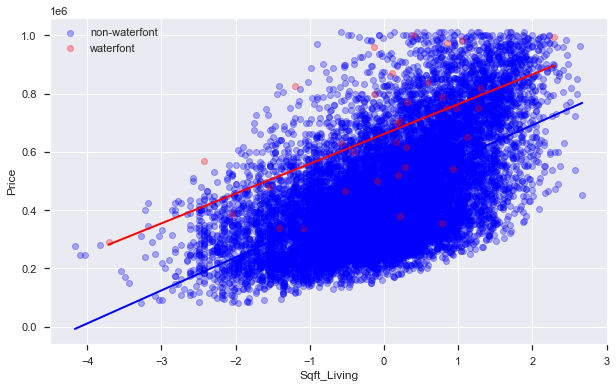

In [44]:
# Create new dataframe with only non-waterfront properties and one with only waterfront properties
non_waterfront = df[['price','sqft_living']].loc[df.waterfront==0].sort_values(by='sqft_living').copy()
waterfront = df[['price','sqft_living']].loc[df.waterfront==1].sort_values(by='sqft_living').copy()

# Instantiate Regression Models
regression_1 = LinearRegression()
regression_2 = LinearRegression()

# Reshape sqft_living data
sqft_1 = non_waterfront.sqft_living.values.reshape(-1,1)
sqft_2 = waterfront.sqft_living.values.reshape(-1,1)

# Fit data to each model
regression_1.fit(sqft_1, non_waterfront.price)
regression_2.fit(sqft_2, waterfront.price)

# Use model to predict price over sqft_living data
pred_1 = regression_1.predict(sqft_1)
pred_2 = regression_2.predict(sqft_2)

# Scatterplot the actual data
plt.figure(figsize=(10,6))
plt.scatter(sqft_1, non_waterfront.price, color='blue', alpha=.3, label='non-waterfont')
plt.scatter(sqft_2, waterfront.price, color='red', alpha=.3, label='waterfont')

# Plot the models
plt.plot(sqft_1, pred_1, color='blue', linewidth=2)
plt.plot(sqft_2, pred_2, color='red', linewidth=2)

plt.ylabel('Price')
plt.xlabel('Sqft_Living')
plt.legend();


As shown above in the plot, the model slopes are very different (non-waterfront v waterfront), meaning that effect sqft_living has on price is drastically different given the property is waterfront or not waterfront.  Since there are only 84 waterfront properties out of 14271, not including this interaction in the model would mean drastically miscalculating the price of this subset of data (waterfront properties). Let's add this interaction to the data and produce <u>Model B4</u>.

In [45]:
df['sqft_living x waterfront'] = df.sqft_living * df.waterfront
X['sqft_living x waterfront'] = X.sqft_living * X.waterfront

In [46]:
# Get features for model B.4
features_B4 = backward_elimation(X, y)

# Select Features 
X_B4 = X[features_B4]

# Create new model with B4 features
X_B4_w_intercept = sm.add_constant(X_B4)
model_B4 = sm.OLS(y, X_B4_w_intercept).fit()

#print R squared value and num interactions
model_B4.summary()

Remove  zipcode_98032
Remove  zipcode_98003
Remove  zipcode_98030
Remove  zipcode_98002
Remove  sqft_living x waterfront
Remove  zipcode_98042
Remove  zipcode_98022
Remove  zipcode_98031


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     879.4
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:39:41   Log-Likelihood:            -1.7257e+05
No. Observations:               13568   AIC:                         3.453e+05
Df Residuals:                   13493   BIC:                         3.458e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.887e+05   2239.421    128.898      0.000    2.84e+05    2.93e+05
bedrooms          -2648.2915    961.978     -2.753      0.006   -4533.903    -762.680
bathrooms          6212.8934   1255.847      4.947      0.000    3751.258    8674.529
sqft_living        7.586e+04   1581.311     47.973      0.000    7.28e+04     7.9e+04
floors            -5285.9339   1074.626     -4.919      0.000   -7392.351   -3179.517
waterfront         2.386e+05   1.44e+04     16.594      0.000     2.1e+05    2.67e+05
condition          1.415e+04    799.371     17.698      0.000    1.26e+04    1.57e+04
grade                4.3e+04   1195.859     35.956      0.000    4.07e+04    4.53e+04
yr_built          -1.197e+04   1223.790     -9.784      0.000   -1.44e+04   -9574.992
sqft_living15      2.385e+04   1194.354     19.968      0.000    2.15e+04    2.62e+04
renovated          3.898e+04   4200.923      9.279      0.000    3.07e+04    4.72e+04
basement          -1.912e+04   1891.386    -10.109      0.000   -2.28e+04   -1.54e+04
zipcode_98004      4.767e+05   8385.669     56.849      0.000     4.6e+05    4.93e+05
zipcode_98005      3.188e+05   8083.200     39.442      0.000    3.03e+05    3.35e+05
zipcode_98006      2.571e+05   5453.687     47.135      0.000    2.46e+05    2.68e+05
zipcode_98007      2.413e+05   8719.775     27.673      0.000    2.24e+05    2.58e+05
zipcode_98008       2.36e+05   6192.638     38.102      0.000    2.24e+05    2.48e+05
zipcode_98010      7.971e+04   1.08e+04      7.392      0.000    5.86e+04    1.01e+05
zipcode_98011       1.32e+05   7368.195     17.918      0.000    1.18e+05    1.46e+05
zipcode_98014      1.194e+05   9852.272     12.116      0.000       1e+05    1.39e+05
zipcode_98019      9.056e+04   8062.381     11.233      0.000    7.48e+04    1.06e+05
zipcode_98023     -2.678e+04   4765.630     -5.618      0.000   -3.61e+04   -1.74e+04
zipcode_98024      1.605e+05   1.33e+04     12.054      0.000    1.34e+05    1.87e+05
zipcode_98027      1.817e+05   5450.076     33.348      0.000    1.71e+05    1.92e+05
zipcode_98028      1.289e+05   6111.922     21.091      0.000    1.17e+05    1.41e+05
zipcode_98029      2.181e+05   5776.913     37.755      0.000    2.07e+05    2.29e+05
zipcode_98033      3.025e+05   5540.105     54.605      0.000    2.92e+05    3.13e+05
zipcode_98034      1.874e+05   4707.318     39.802      0.000    1.78e+05    1.97e+05
zipcode_98038      3.636e+04   4535.298      8.018      0.000    2.75e+04    4.53e+04
zipcode_98040      3.861e+05   8301.192     46.513      0.000     3.7e+05    4.02e+05
zipcode_98045      1.182e+05   7040.903     16.792      0.000    1.04e+05    1.32e+05
zipcode_98052      2.446e+05   4643.631     52.684      0.000    2.36e+05    2.54e+05
zipcode_98053      2.373e+05   5529.401     42.922      0.000    2.26e+05

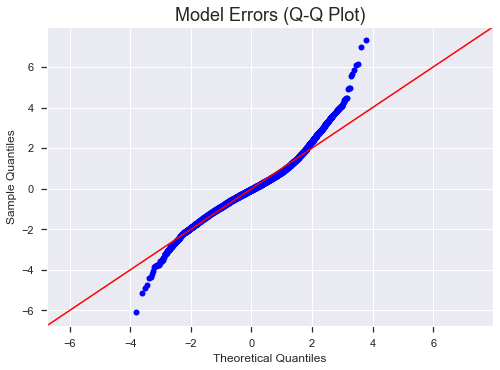

In [47]:
residuals_model_B4 = model_B4.resid
fig = sm.graphics.qqplot(residuals_model_B4, dist=stats.norm, line='45', fit=True)
sns.set_context('talk')
plt.title('Model Errors (Q-Q Plot)');

The above final model B4 has our best yet R squared value of 0.817 and includes a few polynomial terms, a interactions, and zipcode information.  Judging by the Q-Q plot above, it is clear that the residuals do not follow a normal distribution on the tails.  Meaning, our linear regression model does not predict housing prices on the very high or very low end well.

### 7.0 Model Validation
To validate the model we will try two different methods: test-train split, and k fold validation.  Let's start with test train splitting. 
#### Train-Test Split
In the cell below, we will run a loop. Each loop with split the data starting with a 10/90 (train/test) percent split and each time we go through the loop we will add 5% of data to the training data until we reach a 90% train, 10% test split.  For each split percentage, we will create 10 new splits and 10 new models and append the mse train and testing errors.  At the end we will average the errors for each percent split and plot them.

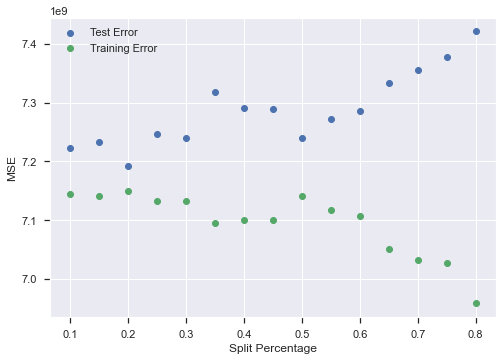

In [35]:
# Your code here
split = 0.1
training_error = []
test_error = []
split_list = []
while split < 0.81:
    train_errors = []
    test_errors = []
    for i in range(0,50):
        linreg = LinearRegression()
        
        #assign split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
        
        X_train_B4 = X_train[features_B4]
        X_test_B4 = X_test[features_B4]
        
        #fit model
        linreg.fit(X_train_B4, y_train)

        #predict y on training and test data
        y_hat_train = linreg.predict(X_train_B4)
        y_hat_test = linreg.predict(X_test_B4)

        #get the residuals
        train_residuals = y_hat_train - y_train
        test_residuals = y_hat_test - y_test

        #get the mse
        mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
        mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
        
        #append errors
        train_errors.append(mse_train)
        test_errors.append(mse_test)

    training_error.append(np.mean(train_errors))
    test_error.append(np.mean(test_errors))
    split_list.append(split)
    split +=.05

plt.scatter(x=split_list, y=test_error, label='Test Error');
plt.scatter(x=split_list, y=training_error, label='Training Error');
plt.xlabel('Split Percentage');
plt.ylabel('MSE');
plt.legend();

#print('Testing Error:', test_error, '\n')
#print('Training Error:', training_error)

From the above loop, it appears that the model over-fits the training data starting around 70% split training.  Lets run the model with a 60/40 (train/test) split and check the error.  We will run the loop 100 times and average the errors.

In [36]:
train_errors = []
test_errors = []
for i in range(0,100):
    #assign split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

    X_train_B4 = X_train[features_B4].copy()
    X_test_B4 = X_test[features_B4].copy()

    #fit model
    linreg.fit(X_train_B4, y_train)

    #predict y on training and test data
    y_hat_train = linreg.predict(X_train_B4)
    y_hat_test = linreg.predict(X_test_B4)

    #get the residuals
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test

    #get the mse
    mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
    mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)

    #append errors
    train_errors.append(mse_train)
    test_errors.append(mse_test)
print('Testing MSE:', round(np.mean(test_error)))
print('Training MSE:', round(np.mean(training_error)))

Testing MSE: 7287753850
Training MSE: 7095331353


#### Cross Validation
To see if there was any variance in the model given the way that we split the training / testing data, we can use split the entire data set into 5 folds.  We will run the model on each of the 5 subsets of data and average each of the R squared values.

In [37]:
# Create and fit the model to the training data
linreg = LinearRegression()
linreg.fit(X[features_B4], y)

# Run the model on each of the 5 subsets of the entire data set
cv_5_results_r2 = cross_val_score(linreg, X, y, cv=5, scoring = 'r2')
cv_5_results_mse = cross_val_score(linreg, X, y, cv=5, scoring = 'neg_mean_squared_error')
print('R-squared:', round(cv_5_results_r2.mean(), 3))
print('MSE:', round(-cv_5_results_mse.mean()))

R-squared: 0.807
MSE: 7305030219


In [38]:
cv_5_results_mse

array([-7.58242228e+09, -7.38511651e+09, -7.07795412e+09, -6.93854669e+09,
       -7.54111150e+09])

As shown above, the MSE is ~ 7,300,000,000

#### Check for Heteroscedasticity

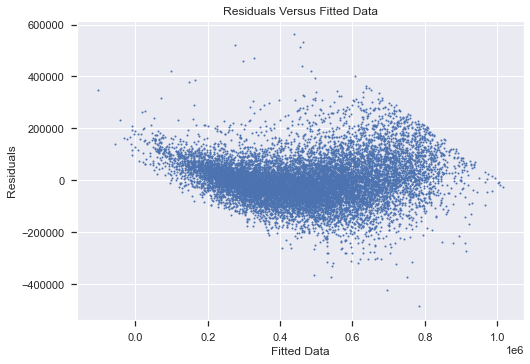

In [50]:
plt.scatter(x=model_B4.predict(X_B1_w_intercept) , y=model_B4.resid, s=1);
plt.title('Residuals Versus Fitted Data');
plt.xlabel('Fitted Data');
plt.ylabel('Residuals');

Residuals do look heteroscedastic. 

### 8.0 Interpreting the Final Model (B4)

During the project, we aimed to model the dataset to predict housing prices. So let's look at the most important predictors of housing price.  We'll start by creating a dataframe with the final model's coefficients and their respective p values. Then we will create a plot showing each coefficient on the x-axis, and the feature on the y-axis.  This visualization shows each feature's influence on the model.  The further away from zero, the more influence it has on the model.

In [51]:
B4_results = pd.DataFrame({'Coefficient': model_B4.params, 'pval':model_B4.pvalues})
B4_results.sort_values(by='Coefficient', ascending=False, inplace = True)
B4_results.drop(index='const', inplace=True)
B4_results.head(60)

,Coefficient,pval
zipcode_98004,470936.323901,0.000000e+00
zipcode_98040,394176.356730,0.000000e+00
zipcode_98112,386059.194680,0.000000e+00
zipcode_98102,384741.685102,1.439017e-173
zipcode_98119,383842.888062,0.000000e+00
zipcode_98109,379904.906528,8.135405e-203
zipcode_98105,355599.262267,0.000000e+00
zipcode_98199,330812.709832,0.000000e+00
zipcode_98005,324030.598374,2.808633e-305
zipcode_98107,309196.950553,0.000000e+00


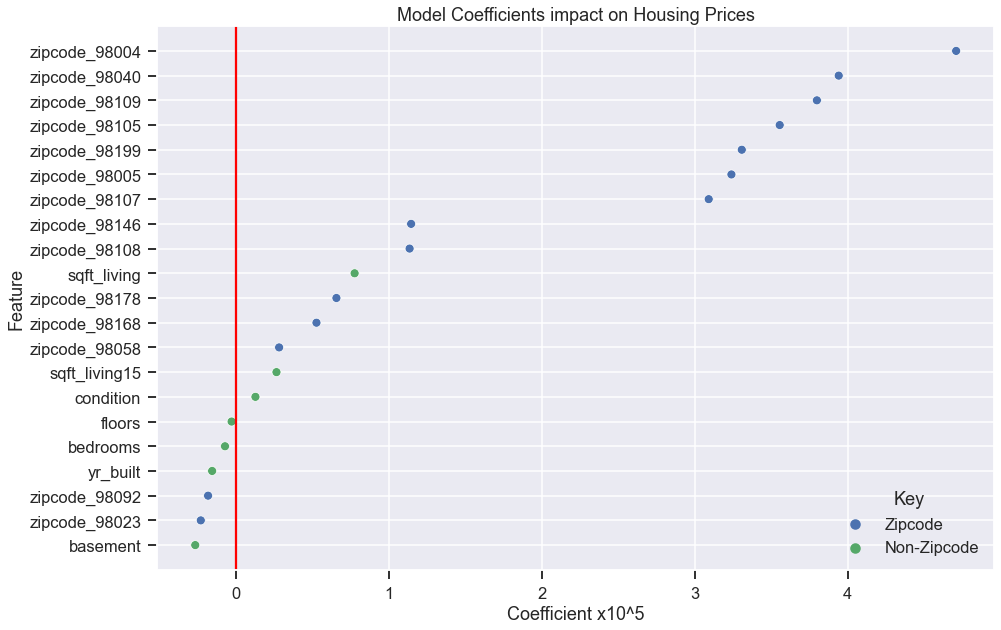

In [52]:
# Drop most of the zipcodes as it make the plot too large
B4_results_mod = B4_results.reset_index().drop(index=range(10,45)
                                              ).drop(index=range(47,52)).drop(index=range(55,61)).drop(index=range(2,5))
B4_results_mod.rename(columns= {'index':'Feature'},inplace=True)

# Add column to differentiate which data points are zipcodes
B4_results_mod['Key'] = B4_results_mod.Feature.apply(lambda x: 'Zipcode' if x[0] == 'z' else 'Non-Zipcode')

# Divide create scientific notation for presentation
B4_results_mod.Coefficient = B4_results_mod.Coefficient/100000

#B4_results_mod_1 = B4_results_mod.loc[B4_results_mod.Key=='Zipcode']
B4_results_mod_2 = B4_results_mod.loc[B4_results_mod.Key=='Non-Zipcode']

# Plot the figure

plt.figure(figsize=(15,10))
sns.set_context('talk')
X_results_B4 = B4_results_mod.Coefficient
Y_results_B4 = B4_results_mod.Feature
sns.scatterplot(x=X_results_B4, y=Y_results_B4, hue=B4_results_mod.Key);
#plt.scatter(x = B4_results_mod_1.Coefficient, y = B4_results_mod_1.Feature);

#Create vertical line to show baseline zero
plt.axvline(x=0, color='red');

plt.yticks(B4_results_mod.Feature)

# Create labels
plt.xlabel('Coefficient x10^5');
plt.title('Model Coefficients impact on Housing Prices');

In [53]:
# Create table of ranked features for presentation
B4_results_mod_2 = B4_results_mod_2.append({'Feature':'zipcode_98004', 'Coefficient': 668063.3387/100000,
                         'pval':0, 'Key':'Zipcode'}, ignore_index=True)

B4_results_mod_2['order']=B4_results_mod_2.Coefficient.apply(lambda x: abs(x))
r = B4_results_mod_2.sort_values(by='order', ascending = False).reset_index().drop(columns=['index', 
                                                                                            'pval', 'Key', 'order'])

r = r.reset_index()
r['index'] = r['index'].apply(lambda x: x+1)
r.rename(columns={'index':'Rank'})


,Rank,Feature,Coefficient
0,1,zipcode_98004,6.680633
1,2,sqft_living,0.777310
2,3,sqft_living15,0.266576
3,4,basement,-0.264439
4,5,yr_built,-0.154039
5,6,condition,0.129015
6,7,bedrooms,-0.069910
7,8,floors,-0.026719


#### Business Insight #1:

The most important factors in housing price according to the model is clearly location.  Each of the top 6 most positive coefficient terms are that of zipcodes.  A quick google of these zipcodes shows them in and around the city of Seattle, which makes sense. The second most important factor is whether or not the property is waterfront, which again makes sense.

What is interesting is that some features, including `floors`, `yr_built`, and `bedrooms` all have negative coefficients. Negative coefficients mean that the more floors, more recently built, and more bedrooms that a house has, the less expensive the house is.  This seems counter-intuitive.  But, since were are mostly talking about the metro areas around Seattle, maybe the data is just bias towards smaller more expensive homes of the city.  Let's see if that is true and make another model considering only zipcode 98004 (top coefficient)

In [54]:
# Take snapshot of dataframe with only zipcode 98004
features_zip = data.loc[data.zipcode=='98004'][['bedrooms']]#, 'bathrooms', 'sqft_living']]
zip_y = data.loc[data.zipcode=='98004'].price

# Create new model with B4 features
X_temp = sm.add_constant(features_zip)
model_temp = sm.OLS(zip_y, X_temp).fit()

#print R squared value and num interactions
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.571
Date:                Mon, 14 Jun 2021   Prob (F-statistic):              0.112
Time:                        12:13:51   Log-Likelihood:                -1330.0
No. Observations:                 101   AIC:                             2664.
Df Residuals:                      99   BIC:                             2669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.266e+05   5.49e+04     13.233      0.000    6.18e+05    8.36e+05
bedrooms    2.522e+04   1.57e+04      1.603      0.112   -5989.114    5.64e+04
==============================================================================
Omnibus:                        2.161   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.186
Skew:                          -0.320   Prob(JB):                        0.335
Kurtosis:                       2.669   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice that the above model has a positive coefficient for bedrooms, just as expected. So something else is going on here. Let's add each feature back to the model one by one and see when the bedrooms coefficient goes negative.

In [55]:
# Take snapshot of dataframe with only zipcode 98004
features_zip = data.loc[data.zipcode=='98004'][['bedrooms', 'bathrooms', 'sqft_living']]
zip_y = data.loc[data.zipcode=='98004'].price

# Create new model with B4 features
X_temp = sm.add_constant(features_zip)
model_temp = sm.OLS(zip_y, X_temp).fit()

#print R squared value and num interactions
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     10.52
Date:                Mon, 14 Jun 2021   Prob (F-statistic):           4.71e-06
Time:                        12:13:54   Log-Likelihood:                -1317.1
No. Observations:                 101   AIC:                             2642.
Df Residuals:                      97   BIC:                             2653.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.368e+05   5.35e+04     11.905      0.000    5.31e+05    7.43e+05
bedrooms    -1.205e+04   1.59e+04     -0.758      0.450   -4.36e+04    1.95e+04
bathrooms    7245.8282   2.68e+04      0.270      0.788    -4.6e+04    6.05e+04
sqft_living   102.8474     30.994      3.318      0.001      41.332     164.363
==============================================================================
Omnibus:                        4.600   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.108
Skew:                          -0.486   Prob(JB):                        0.128
Kurtosis:                       3.182   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Business Insight #2:

After adding `sqft_living` to the model, the coefficient for bedrooms has gone negative, AND we got a new note [2] from the regression output.  The note indicate a strong multicolinearity.  That makes a ton of sense, the bedrooms and sqft should be colinear as more bedrooms inherinetly means more square feet (usually). If we go back up to the correlation matrix at the beginning we will see that these two features are highly correlated (0.74).  So, our model has picked up that as both bedrooms and sqft_living increase, price should also increase. However, since the model knows that bedrooms and sqft_living are related, its is accounting for the data with high sqft_living, and less bedrooms.  This is actually a cool and nuanced point, **the model is saying that houses with a lot of square feet, but few bedrooms (or in otherwords more open and spacious) have higher prices.**

**Now lets use the model to see where we can get the best and the worst deals:** 

As noted before, the data looks pretty linear on the Q-Q plots except at the tails. At the tails, it's not linear at all. Let's look at a plot of the residuals verus price to see where our model fails most often.

In [56]:
linreg = LinearRegression()

#assign split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train_B4 = X_train[features_B4]
X_test_B4 = X_test[features_B4]

#fit model
linreg.fit(X_train_B4, y_train)

#predict y on training and test data
y_hat_train = linreg.predict(X_train_B4)
y_hat_test = linreg.predict(X_test_B4)

#get the residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

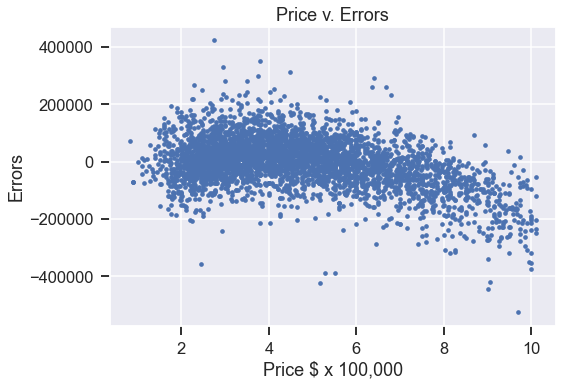

In [57]:
plt.scatter(x = y_test/100000, y = test_residuals, s=10);
plt.xlabel('Price $ x 100,000');
plt.ylabel('Errors');
plt.title('Price v. Errors');

Look like the model has very high residuals when price is the greatest. Let's get the top 100 most positive and 10 most negative residuals.  We'll average each column of these data points with the greatest and least residuals, and see how different they are from the average of each feature of the entire dataset.  This should tell us which features were exceptionally high or low compared to the average and drove the price up or down.

In [58]:
# Add residuals to the model
residuals = df.copy()
residuals['residuals'] = model_B4.resid

# Get the top 100 / 10 most negative and positive residuals
bottom_10 = residuals.sort_values(by='residuals', ascending=True).tail(10).mean()
top_10 = residuals.sort_values(by='residuals', ascending=True).head(50).mean()

# Get the means and standard deviations of each column
means = []
stdevs = []
#for col in df.columns[1:12]:
for col in df.columns[1:-4]:
    means.append(df[col].mean())
    stdevs.append(df[col].std())

# Calculate the difference between the top 10 residuals means and the total dataset means
#means_delta_bottom = bottom_10[1:12] - means
#means_delta_top= top_10[1:12] - means

means_delta_bottom = bottom_10[1:-5] - means
means_delta_top= top_10[1:-5] - means

# Divide the difference in means by the standard deviation to see how far away each residual mean is
num_std_bottom = means_delta_bottom/stdevs
num_std_top = means_delta_top/stdevs

# Bottom Residuals: New dataframe to show the means_delta, std, and number of standard away, sort it by num_std_away
residual_bottom = pd.DataFrame({'means_delta':means_delta_bottom, 'std':stdevs, 'num_std_away': num_std_bottom})
residual_bottom = residual_bottom.sort_values(by='num_std_away', ascending=False).reset_index().head(10)
residual_bottom.rename(columns={'index':'Feature'}, inplace=True)
#residual_bottom.loc[residual_bottom.Feature !='grade']
residual_bottom

,Feature,means_delta,std,num_std_away
0,zipcode_98070,0.094988,0.070619,1.345080
1,zipcode_98072,0.086512,0.115355,0.749969
2,zipcode_98031,0.085702,0.118722,0.721868
3,zipcode_98106,0.084154,0.124885,0.673853
4,zipcode_98126,0.083048,0.129095,0.643312
5,zipcode_98092,0.082532,0.131010,0.629969
6,zipcode_98033,0.081574,0.134490,0.606546
7,zipcode_98125,0.079363,0.142170,0.558226
8,zipcode_98133,0.075678,0.154052,0.491249
9,zipcode_98115,0.075088,0.155861,0.481764


#### Business Insight #3:

From the above table, we can see that people who got the best deal (paid less than the model would have predicted) were those who had more sqft and more bathrooms than the average.  Additionally those who purchased homes in 981006, 98107, and 98199 seemed to spend less than the model predicted.

In [59]:
# Top Residuals: New dataframe to show the means_delta, std, and number of standard away, sort it by num_std_away
residual_top = pd.DataFrame({'means_delta':means_delta_top, 'std':stdevs, 'num_std_away': num_std_top})
residual_top = residual_top.sort_values(by='num_std_away', ascending=False).reset_index().head()
residual_top.rename(columns={'index':'Feature'})
residual_top.index = [1,2,3,4,5]
residual_top.rename(columns={'index':'Feature'})

,Feature,means_delta,std,num_std_away
1,zipcode_98004,0.092556,0.085960,1.076734
2,waterfront,0.037420,0.050726,0.737696
3,zipcode_98112,0.053367,0.081177,0.657410
4,renovated,0.107718,0.176754,0.609424
5,zipcode_98109,0.036241,0.061196,0.592211


#### Business Insight #4:

As we can see from the table above, those who got the worst deal and paid a premium (paid more than the model predicted) were by and large those with waterfront properties.  The second in this category were those who bought renovated houses. Also, those who bought houses in 98112, 98004, and 98070 seemed to spend less than the model predicted.